In [40]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AlphaRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(AlphaRNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.W_ih = nn.Parameter(torch.Tensor(hidden_size, input_size))
        self.W_hh = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_ih = nn.Parameter(torch.Tensor(hidden_size))
        self.b_hh = nn.Parameter(torch.Tensor(hidden_size))
        self.alpha = nn.Parameter(torch.Tensor(1))

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.W_ih, a=np.sqrt(5))
        nn.init.kaiming_uniform_(self.W_hh, a=np.sqrt(5))
        nn.init.zeros_(self.b_ih)
        nn.init.zeros_(self.b_hh)
        nn.init.constant_(self.alpha, 0.5)

    def forward(self, input, hidden):
        h_next = torch.sigmoid(self.alpha) * hidden + (1 - torch.sigmoid(self.alpha)) * torch.tanh(
            F.linear(input, self.W_ih, self.b_ih) + F.linear(hidden, self.W_hh, self.b_hh)
        )
        return h_next

class AlphaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(AlphaRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cells = nn.ModuleList([AlphaRNNCell(input_size if i == 0 else hidden_size, hidden_size) for i in range(num_layers)])

    def forward(self, input, hidden=None):
        batch_size, seq_len, _ = input.size()
        if hidden is None:
            hidden = self.init_hidden(batch_size)

        outputs = []
        for t in range(seq_len):
            x = input[:, t, :]
            for i, cell in enumerate(self.cells):
                hidden[i] = cell(x, hidden[i])
                x = hidden[i]
            outputs.append(x.unsqueeze(1))

        return torch.cat(outputs, dim=1), hidden

    def init_hidden(self, batch_size):
        return [torch.zeros(batch_size, self.hidden_size, device=self.cells[0].W_ih.device) for _ in range(self.num_layers)]

In [53]:
TICKER = '^GSPC'
START_DATE = '2000-01-01'
END_DATE = '2024-07-18'

data = yf.download(
    TICKER,
    start = START_DATE,
    end = END_DATE,
    interval = '1d',
    progress = False
)

In [54]:
prices = data['Close'].resample('W').last().pct_change().dropna().values

In [55]:
prices = torch.tensor(prices, dtype=torch.float32).unsqueeze(1)  # Shape (N, 1)

In [56]:
sequence_length = 30
sequences = []
targets = []
for i in range(len(prices) - sequence_length):
    sequences.append(prices[i:i + sequence_length])
    targets.append(prices[i + sequence_length])

sequences = torch.stack(sequences)
targets = torch.stack(targets)

train-test split

In [57]:
train_size = int(len(sequences) * 0.8)
train_sequences = sequences[:train_size]
train_targets = targets[:train_size]
test_sequences = sequences[train_size:]
test_targets = targets[train_size:]

In [58]:
input_size = 1
hidden_size = 20
num_layers = 1
model = AlphaRNN(input_size, hidden_size, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [59]:
NUM_EPOCHS = 100

for epoch in range(NUM_EPOCHS):
    model.train()
    optimizer.zero_grad()
    output, hidden = model(train_sequences)
    loss = criterion(output[:, -1, -1].reshape(-1), train_targets.reshape(-1))
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {loss.item()}')

Epoch 1/100, Loss: 0.0006825895397923887
Epoch 11/100, Loss: 0.0006799881812185049
Epoch 21/100, Loss: 0.0006599273183383048
Epoch 31/100, Loss: 0.0006524503696709871
Epoch 41/100, Loss: 0.000646056781988591
Epoch 51/100, Loss: 0.0006408365443348885
Epoch 61/100, Loss: 0.0006367830210365355
Epoch 71/100, Loss: 0.0006332503398880363
Epoch 81/100, Loss: 0.0006300476961769164
Epoch 91/100, Loss: 0.0006271118763834238


In [60]:
model.eval()
with torch.no_grad():
    test_output, test_hidden = model(test_sequences)
    test_predictions = test_output[:, -1, -1].reshape(-1)
    hidden_predictions = test_hidden[0][:, -1].reshape(-1)

In [61]:
temp = pd.Series(
    test_predictions.cpu().numpy(),
    index = data['Close'].resample('W').last().index[-250:],
    name = 'Prediction'
)

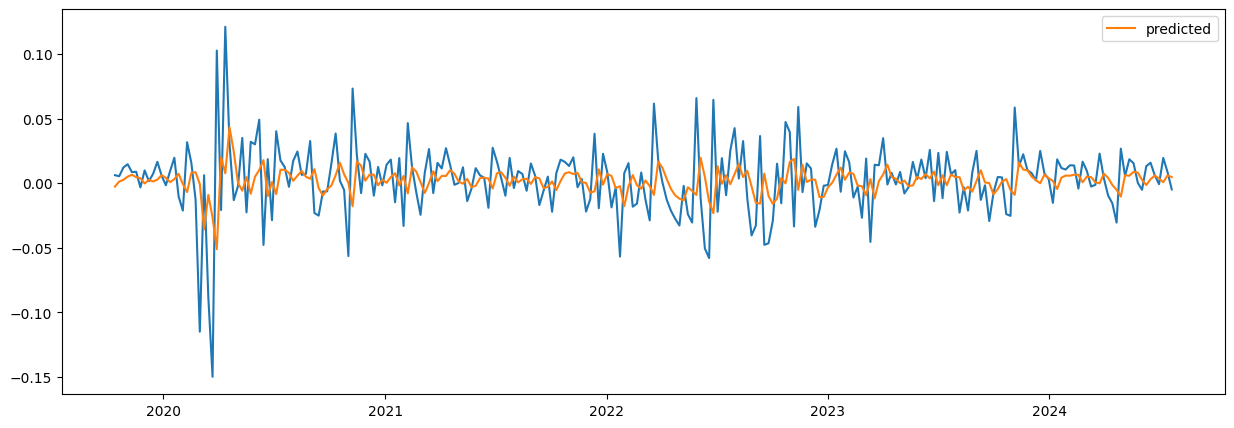

In [62]:
plt.figure(figsize = (15, 5))
plt.plot(data['Close'].resample('W').last().pct_change().iloc[-250:])
plt.plot(temp, label = 'predicted')
plt.legend()
plt.show()